In [1]:
# Dependencies
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import numpy as np
import pandas as pd
import datetime as dt
from datetime import datetime
from scipy import stats

# Reflect Tables into SQLAlchemy ORM

In [2]:
# Python SQL toolkit and Object Relational Mapper ("ORM")
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [3]:
# Creating engine for the "hawaii.sqlite" database
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [4]:
# Reflecting the existing database into a new model
Base = automap_base()
# Reflecting the tables
Base.prepare(engine, reflect = True)

In [5]:
# Displaying all classes (tables) that automap found
Base.classes.keys()

['measurement', 'station']

In [6]:
# Saving references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [7]:
# Creating session (link) from Python to the database
session = Session(engine)
conn = engine.connect()

In [8]:
# Displaying all column names from the "measurement" table
[column.key for column in measurement.__table__.columns]

['id', 'station', 'date', 'prcp', 'tobs']

In [9]:
# Displaying all column names from the "station" table
[column.key for column in station.__table__.columns]

['id', 'station', 'name', 'latitude', 'longitude', 'elevation']

# Exploratory Precipitation Analysis

In [10]:
# Displaying the most recent date in the data set
latest_date = session.query(func.max(measurement.date)).first()
latest_date

('2017-08-23')

In [11]:
# Querying to retrieve the last 12 months (from most recent date available to one year prior) of precipitation data and plotting the results
latest_date = dt.date(2017, 8, 23)
year_range = latest_date - dt.timedelta(days=365)
year_range

datetime.date(2016, 8, 23)

In [12]:
# Querying to retrieve the data and precipitation levels
prcp_data = session.query(measurement.date, measurement.prcp).filter(measurement.date >= year_range).all()

In [13]:
# Saving/displaying the query results as a DataFrame
prcp_data_df = pd.DataFrame(prcp_data).sort_values("date")
prcp_data_df.reset_index(drop=True, inplace=True)
prcp_data_df.rename(columns={"prcp": "precipitation"}, inplace=True)
prcp_data_df.head()

,date,precipitation
0,2016-08-23,0.00
1,2016-08-23,NaN
2,2016-08-23,1.79
3,2016-08-23,0.05
4,2016-08-23,0.15


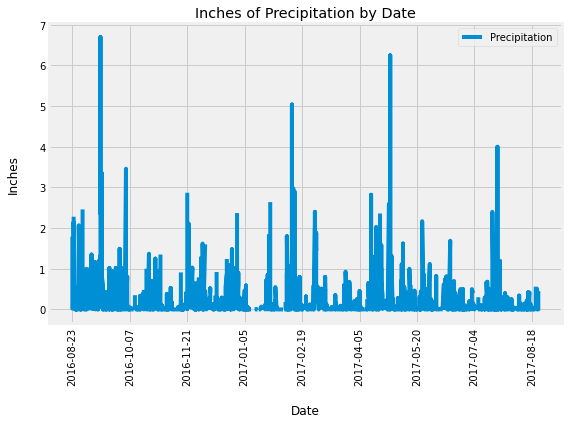

In [14]:
# Plotting the data
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(prcp_data_df["date"],prcp_data_df["precipitation"])
loc = plticker.MultipleLocator(base=45)
ax.xaxis.set_major_locator(loc)
plt.title("Inches of Precipitation by Date")
plt.xlabel("\nDate")
plt.ylabel("Inches\n")
plt.xticks(rotation="90", horizontalalignment="center")
plt.legend(["Precipitation"])
plt.tight_layout()
plt.show()

In [15]:
# Calculating the summary statistics for the precipitation data
prcp_data_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [16]:
# Querying to calculate the total number stations in the dataset
stations = session.query(station.station).count()
stations

9

In [17]:
# Querying to find the most active stations (by most records) and displaying the results in descending order (most active first)
station_activity = session.query(measurement.station, func.count(measurement.station)).group_by(measurement.station).order_by(func.count(measurement.station).desc()).all()
station_activity

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [18]:
active_id = station_activity[0][0]
print(f"The most active station is {active_id} with {station_activity[0][1]} total records.")

The most active station is USC00519281 with 2772 total records.


In [19]:
# Calculating the lowest, highest, and average temperature for the most active station id obtained from the previous query
low_temp = session.query(func.min(measurement.tobs)).filter(measurement.station == active_id).scalar()
high_temp = session.query(func.max(measurement.tobs)).filter(measurement.station == active_id).scalar()
avg_temp = round(session.query(func.avg(measurement.tobs)).filter(measurement.station == active_id).scalar(),2)

print(f"For station {active_id}:\n\
The lowest recorded temperature was {low_temp} °F.\n\
The highest recorded temperature was {high_temp} °F.\n\
The average recorded temperature was {avg_temp} °F.")

For station USC00519281:
The lowest recorded temperature was 54.0 °F.
The highest recorded temperature was 85.0 °F.
The average recorded temperature was 71.66 °F.


In [20]:
# Querying the last 12 months of temperature observation data for the most active station id
temps = session.query(measurement.date, measurement.tobs).filter(measurement.date >= year_range, measurement.station == active_id).all()
temps_df = pd.DataFrame(temps).sort_values("date")
temps_df

,date,tobs
0,2016-08-23,77.0
1,2016-08-24,77.0
2,2016-08-25,80.0
3,2016-08-26,80.0
4,2016-08-27,75.0
...,...,...
347,2017-08-14,77.0
348,2017-08-15,77.0
349,2017-08-16,76.0
350,2017-08-17,76.0


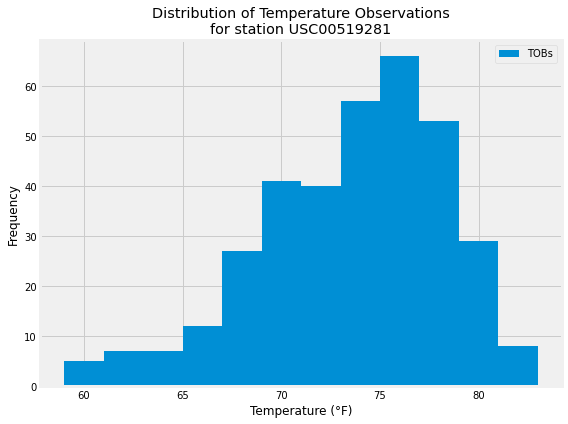

In [21]:
# Plotting the data as a histogram
plt.figure(figsize=(8,6))
plt.hist(temps_df["tobs"], bins = 12)
plt.title(f"Distribution of Temperature Observations\n\
for station {active_id}")
plt.xlabel("Temperature (°F)")
plt.ylabel("Frequency")
plt.legend(["TOBs"])
plt.tight_layout()
plt.show()

# Bonus: Temperature Analysis I & II

## Part I

In [22]:
# Identifying the average temperature for June
june_temps = session.query(measurement.station, func.avg(measurement.tobs)).filter(func.strftime("%m", measurement.date) == "06").group_by(measurement.station).all()
june_temps_df = pd.DataFrame(june_temps, columns = ["station", "avg_temp"])
jun_avg = june_temps_df["avg_temp"].mean()
june_temps_df

,station,avg_temp
0,USC00511918,74.139394
1,USC00513117,74.050847
2,USC00514830,76.005376
3,USC00516128,71.937220
4,USC00517948,76.655405
5,USC00518838,73.394737
6,USC00519281,73.271186
7,USC00519397,77.559322
8,USC00519523,76.668103


In [23]:
# Identifying the average temperature for December
dec_temps = session.query(measurement.station, func.avg(measurement.tobs)).filter(func.strftime("%m", measurement.date) == "12").group_by(measurement.station).all()
dec_temps_df = pd.DataFrame(dec_temps, columns = ["station", "avg_temp"])
dec_avg = dec_temps_df["avg_temp"].mean()
dec_temps_df

,station,avg_temp
0,USC00511918,69.684211
1,USC00513117,71.069444
2,USC00514830,73.224719
3,USC00516128,69.291262
4,USC00517948,71.834862
5,USC00518838,72.421053
6,USC00519281,69.903226
7,USC00519397,71.109524
8,USC00519523,72.433333


In [24]:
# Displaying the aggregate average temperatures for each month
avg_temps_df = pd.DataFrame({"month": ["jun", "dec"], "avg_temp": [jun_avg, dec_avg]})
avg_temps_df.set_index("month", inplace=True)
avg_temps_df

,avg_temp
month,
jun,74.85351
dec,71.21907


In [25]:
# Running an unpaired t-test to determine whether the difference in the means is statistically significant
stats.ttest_ind(june_temps_df["avg_temp"], dec_temps_df["avg_temp"])

Ttest_indResult(statistic=4.615865424404701, pvalue=0.00028626292761018595)

## Part II

In [26]:
# Defining a function called "calc_temps" which will accept start date and end date in the format "%Y-%m-%d" and return the min, max, and average temperatures for that date range
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).\
        filter(measurement.date >= start_date).filter(measurement.date <= end_date).all()

In [27]:
# Using the function "calc_temps" to calculate the tmin, tavg, and tmax for a year in the data set
tmin, tavg, tmax = calc_temps("2016-06-01", "2017-06-01")[0]
print(f"{tmin}, {tavg}, {tmax}")

58.0, 74.38633377135348, 87.0


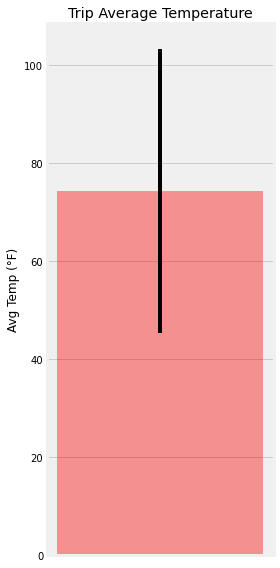

In [28]:
# Plotting the data as a bar chart with the average temperature for bar height and the peak-to-peak (tmax-tmin) value as the y error bar
plt.figure(figsize=(4,8))
plt.bar(1, height=tavg, yerr=tmax-tmin, color="r", alpha=0.4)
plt.xticks([])
plt.title(f"Trip Average Temperature")
plt.ylabel("Avg Temp (°F)")
plt.tight_layout()
plt.show()

### Daily Rainfall Totals

In [29]:
# Calculating the average daily amount of rainfall per weather station for the above dates, sorting in descending order by precipitation amount
station_prcp = session.query(station.station, station.name, station.latitude, station.longitude, station.elevation, func.avg(measurement.prcp)).\
filter(station.station == measurement.station).\
filter(measurement.date>="2016-06-01").filter(measurement.date<="2017-06-01").\
group_by(measurement.station).order_by(measurement.prcp.desc()).all()

# Displaying the results in a DataFrame
station_prcp_df = pd.DataFrame(station_prcp, columns = ["station_id", "station_name", "lat", "lng","elevation", "precipitation"])
station_prcp_df

,station_id,station_name,lat,lng,elevation,precipitation
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,0.535154
1,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,0.264590
2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,0.178197
3,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.146875
4,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.131141
5,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.063508
6,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,0.094262


In [30]:
# Defining a function called "daily_normals" which will calculate the averages for min, max, and avg temperature for all historic data matching a specific month and day

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", measurement.date) == date).all()

In [31]:
# Selecting a random week in the data set for calculation of daily normal temperature values
start_date = "2016-06-01"
end_date = "2016-06-07"

# Using the start and end date to create a range of dates
date_list = pd.date_range(start_date, end_date).tolist()

# Stripping the year and saving a list of strings in the format "%m-%d"
date_list_cleaned = [date_list[i].strftime("%m-%d") for i in range(len(date_list))]

# Using the function "daily_normals" to calculate the historical daily normal values for the selected week, appending tuples of calculations into a list called "normals"
normals = []

for i in range(len(date_list_cleaned)):
    daily_normal = list(np.ravel(daily_normals(date_list_cleaned[i])))
    normals.append(daily_normal)

In [32]:
# Loading the previous results into a DataFrame and adding the selected date range as the date index
daily_df = pd.DataFrame(normals, columns=["min", "avg", "max"])
daily_df["date"] = date_list
daily_df["avg"] = round(daily_df["avg"],2)
daily_df.set_index("date", inplace=True)
daily_df

,min,avg,max
date,,,
2016-06-01,64.0,74.61,81.0
2016-06-02,65.0,74.40,81.0
2016-06-03,65.0,74.03,80.0
2016-06-04,65.0,73.82,81.0
2016-06-05,68.0,74.85,81.0
2016-06-06,70.0,75.18,80.0
2016-06-07,68.0,75.07,81.0


In [33]:
# Calculating the average temperature for the first week of June
avg_week = daily_df["avg"].mean()
avg_week

74.5657142857143

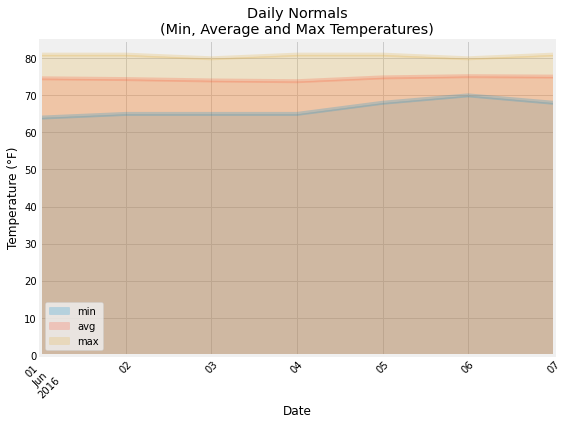

In [34]:
# Plotting the daily normals as an area plot
daily_df.plot(kind="area",stacked=False,rot=45,alpha=.22,figsize=(8,6))
plt.grid(b=True, which='minor', axis='both')
plt.title("Daily Normals\n(Min, Average and Max Temperatures)")
plt.xlabel("Date")
plt.ylabel("Temperature (°F)")
plt.tight_layout()
plt.show()

In [35]:
# Closing the session
session.close()